In [1]:
# Configuration OpenMP
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Imports des modules locaux
# from data_loading import BurgersDatasetSimple
from data_loading import *
from models import *
from training import *
from visualization import *
from evaluation import *

# Import explicite des nouvelles fonctions (pour s'assurer qu'elles sont disponibles)
from evaluation import generate_model_predictions, evaluate_model_on_sample, display_evaluation_results

print("✓ Modules rechargés avec succès")

TypeError: 'type' object is not subscriptable

### Env configuration

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# Data path configuration
project_root = Path(os.getcwd()).parent.parent  # go back from modular -> NFTM_for_Physic -> NFTM
data_dir = project_root / "Data"
print(f"Data directory: {data_dir}")

models_dir = project_root /"NFTM_for_Physic"/ "saved_models"

# Check file existence
files_burger = {
    0.001: data_dir / "burgers1D_training_data_Nu0.001.npz",
    0.01:  data_dir / "burgers1D_training_data_Nu0.01.npz",
    0.1:   data_dir / "burgers1D_training_data_Nu0.1.npz",
    0.5:   data_dir / "burgers1D_training_data_Nu0.5.npz",
}

print("\nAvailable data files:")
for nu, filepath in files_burger.items():
    exists = "✓" if filepath.exists() else "✗"
    print(f"  {exists} Nu={nu}: {filepath.name}")

Device used: cuda
Data directory: c:\Dev\CentralSupelec\BDRP\NFTM\Data

Available data files:
  ✓ Nu=0.001: burgers1D_training_data_Nu0.001.npz
  ✓ Nu=0.01: burgers1D_training_data_Nu0.01.npz
  ✓ Nu=0.1: burgers1D_training_data_Nu0.1.npz
  ✓ Nu=0.5: burgers1D_training_data_Nu0.5.npz


### Dataset Configuration and Loading

In [ ]:
# ========== DATASET CONFIGURATION ==========
# Change this parameter to switch between datasets:
# - "simple": Uses BurgersDatasetSimple (one trajectory per viscosity from Data/ folder)
# - "generated": Uses BurgersViscosityDataset (multiple samples from generated_1d_burgers/ folder)

DATASET_TYPE = "generated"  # Change to "generated" to use the other dataset

batch_size = 4
history_len = 3  # Only used for "generated" dataset

# ========== DATASET LOADING ==========
if DATASET_TYPE == "simple":
    print("📁 Using BurgersDatasetSimple with Data/ folder files")
    train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
    test_loader = None  # No test split for simple dataset
    
elif DATASET_TYPE == "generated":
    print("📁 Using BurgersViscosityDataset with generated samples")
    # Path to your generated samples folder
    generated_data_dir = project_root / "NFTM_for_Physic" / "generated_1d_burgers"
    
    if not generated_data_dir.exists():
        print(f"❌ Generated data directory not found: {generated_data_dir}")
        print("Creating a fallback to simple dataset...")
        DATASET_TYPE = "simple"
        train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
        test_loader = None
    else:
        try:
            train_loader, test_loader = create_generated_dataloaders(
                root_dir=str(generated_data_dir),
                history_len=history_len,
                batch_size=batch_size,
                train_ratio=0.8
            )
            print(f"✓ Generated dataset loaded from: {generated_data_dir}")
            print(f"✓ Train/test split created with ratio 0.8")
        except Exception as e:
            print(f"❌ Error loading generated dataset: {e}")
            print("Falling back to simple dataset...")
            DATASET_TYPE = "simple"
            train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)
            test_loader = None

else:
    raise ValueError(f"Unknown dataset type: {DATASET_TYPE}. Use 'simple' or 'generated'")

📁 Using BurgersViscosityDataset with generated samples
✓ Generated dataset loaded from: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers
✓ Train/test split created with ratio 0.8
✓ Generated dataset loaded from: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers
✓ Train/test split created with ratio 0.8


Sample 301 | nu=0.1000
 initial_field: torch.Size([128])
 trajectory   : torch.Size([256, 128])


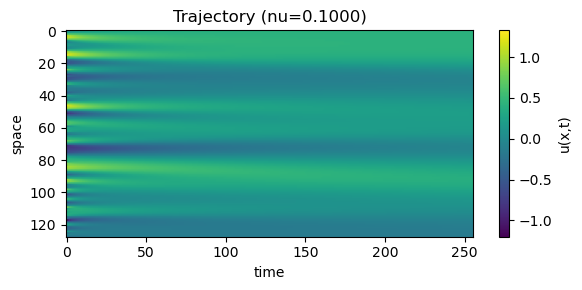

In [ ]:
if DATASET_TYPE == "simple":
    # For simple dataset, show sample from the raw dataset
    dataset = train_loader.dataset
    show_random_sample(dataset)
elif DATASET_TYPE == "generated":
    # For generated dataset, show sample from the training set
    dataset = train_loader.dataset
    if hasattr(dataset, 'dataset'):  # Handle random_split wrapper
        dataset = dataset.dataset
    show_random_sample(dataset)

### Load model

In [ ]:
# Model configuration
patch_radius = 1
patch_size = 2 * patch_radius + 1
chunk_size = 3

# --- CNN Model --- #
# model = CNNControllerPatch(patch_size=patch_size)

# --- RNN Model  --- #
model = RNNControllerPatch(patch_size=patch_size)

# --- CNN Model with time history --- #
# model = CNNControllerHistory(patch_size=patch_size, hidden_size=64)

# --- Load a saved model # 
# LOAD_MODEL_NAME = "my_trained_model.pth"  # Set to filename like "my_model.pth" to load a model

# if LOAD_MODEL_NAME is not None:
#     print(f"📥 Loading model from: {LOAD_MODEL_NAME}")
#     model = torch.load(models_dir / LOAD_MODEL_NAME, map_location=device, weights_only=False)
#     print(f"✓ Model loaded successfully")
# else:
#     # Create new model if not loading
#     model = CNNControllerHistory(patch_size=patch_size, hidden_size=64)
#     print("🆕 Created new model")

model = model.to(device)

print(f"Model information:")
print(f"  - Patch radius: {patch_radius}")
print(f"  - Patch size: {patch_size}")
print(f"  - Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nModel architecture:")
print(model)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL models.CNNControllerHistory was not an allowed global by default. Please use `torch.serialization.add_safe_globals([CNNControllerHistory])` or the `torch.serialization.safe_globals([CNNControllerHistory])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

### Model training

In [ ]:
num_epochs = 10

print(f"🚀 Starting training for {num_epochs} epochs with {DATASET_TYPE} dataset...")
print("=" * 60)

# Select appropriate training function based on model type
model_type = model.__class__.__name__

if model_type == "CNNControllerPatch":
    print(f"🔧 Training CNN model...")
    train_losses = train_cnn_patch(
        model,
        dataloader=train_loader,
        device=device,
        num_epochs=num_epochs,
        patch_radius=patch_radius,
    )
    
elif model_type == "RNNControllerPatch":
    print(f"🔧 Training RNN model...")
    train_losses = train_rnn_patch(
        model,
        dataloader=train_loader,
        device=device,
        num_epochs=num_epochs,
        patch_radius=patch_radius,
        chunk_size=chunk_size,
    )
    
elif model_type == "CNNControllerHistory":
    print(f"🔧 Training CNN History model...")
    # Note: You might need to implement train_cnn_history function
    # For now, using RNN training as fallback
    train_losses = train_rnn_patch(
        model=model,
        dataloader=train_loader,
        device=device,
        chunk_size=chunk_size,
        num_epochs=num_epochs,
        patch_radius=patch_radius,
    )
else:
    raise ValueError(f"Unknown model type: {model_type}")

print(f"\n Training completed!")
print(f" Dataset used: {DATASET_TYPE}")
print(f" Model trained: {model_type}")
print(f" Final loss: {train_losses[-1]:.6f}")

🚀 Starting training for 10 epochs with generated dataset...
🔧 Training CNN History model...
[RNN] Epoch 1/10 - MSE: 1.003473e-02
[RNN] Epoch 1/10 - MSE: 1.003473e-02
[RNN] Epoch 2/10 - MSE: 9.941344e-03
[RNN] Epoch 2/10 - MSE: 9.941344e-03
[RNN] Epoch 3/10 - MSE: 9.373102e-03
[RNN] Epoch 3/10 - MSE: 9.373102e-03
[RNN] Epoch 4/10 - MSE: 9.054411e-03
[RNN] Epoch 4/10 - MSE: 9.054411e-03
[RNN] Epoch 5/10 - MSE: 8.984238e-03
[RNN] Epoch 5/10 - MSE: 8.984238e-03
[RNN] Epoch 6/10 - MSE: 8.972590e-03
[RNN] Epoch 6/10 - MSE: 8.972590e-03
[RNN] Epoch 7/10 - MSE: 9.871228e-03
[RNN] Epoch 7/10 - MSE: 9.871228e-03
[RNN] Epoch 8/10 - MSE: 9.363536e-03
[RNN] Epoch 8/10 - MSE: 9.363536e-03
[RNN] Epoch 9/10 - MSE: 9.153647e-03
[RNN] Epoch 9/10 - MSE: 9.153647e-03
[RNN] Epoch 10/10 - MSE: 8.797892e-03

✅ Training completed!
📊 Dataset used: generated
🏗️ Model trained: CNNControllerHistory
📉 Final loss: 0.008798
[RNN] Epoch 10/10 - MSE: 8.797892e-03

✅ Training completed!
📊 Dataset used: generated
🏗️ Mod

### Loss funciton

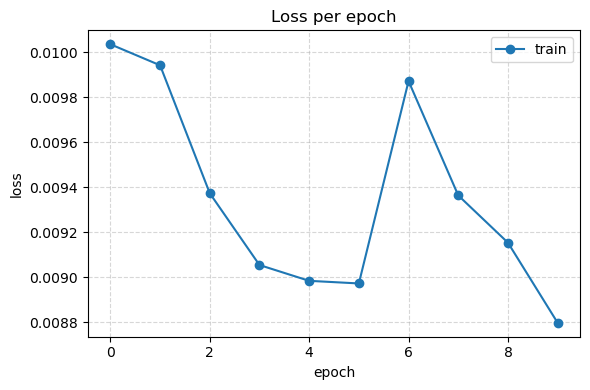

Final loss: 0.008798
Loss reduction: 12.33%


In [ ]:
plot_losses(train_losses)

print(f"Final loss: {train_losses[-1]:.6f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1])/train_losses[0]*100):.2f}%")

### Generate prediction

### Visualization

Generating predictions for nu = 0.1000
True trajectory shape: torch.Size([256, 128])
Model type: CNNControllerHistory
Sequential mode: 253 prédictions avec chunk_size=3
  step 0/253
  step 10/253
  step 20/253
  step 30/253
  step 40/253
  step 50/253
  step 60/253
  step 70/253
  step 80/253
  step 90/253
  step 100/253
  step 110/253
  step 120/253
  step 130/253
  step 140/253
  step 150/253
  step 160/253
  step 170/253
  step 180/253
  step 190/253
  step 200/253
  step 210/253
  step 220/253
  step 230/253
  step 240/253
  step 250/253

Generated predictions shape: torch.Size([256, 128])


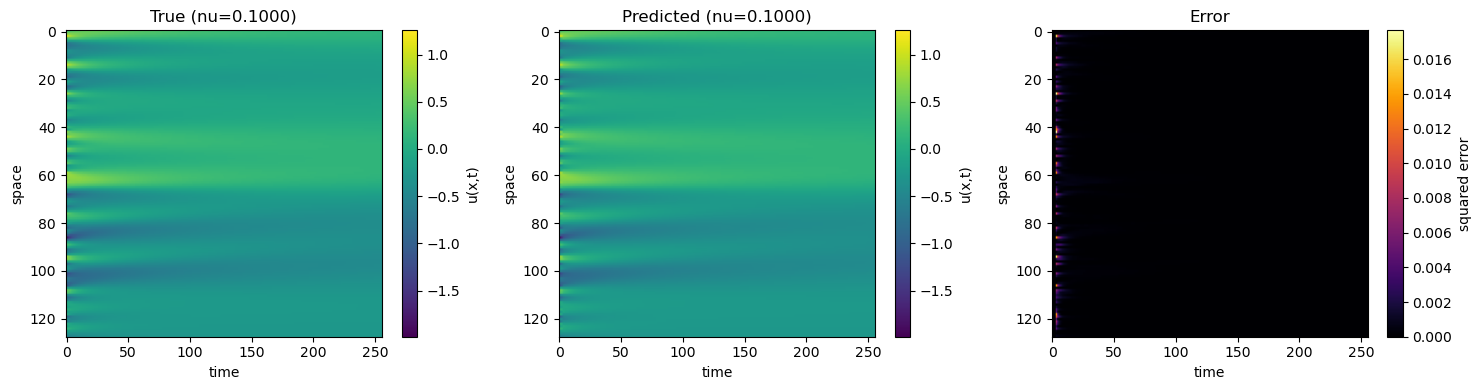

In [ ]:
# Generate predictions for visualization
true_traj, pred_traj, nu_value = generate_model_predictions(
    model, 
    train_loader, 
    device, 
    patch_radius, 
    verbose=True, 
    chunk_size=chunk_size
)

# Visualize trajectories
plot_trajectories(true_traj, pred_traj, title_suffix=f" (nu={nu_value:.4f})")

### Evaluation

Evaluation metrics:
  - PSNR: 36.836 dB
  - SSIM: 0.999
  - MSE: 0.000207
  - R²: 0.9998


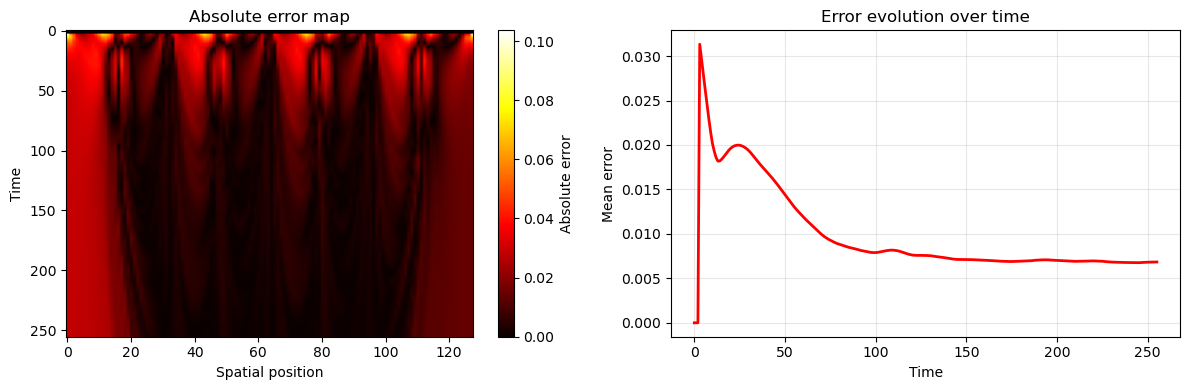

In [ ]:
# Complete evaluation with dedicated function
evaluation_results = evaluate_model_on_sample(
    model, 
    train_loader, 
    device, 
    patch_radius, 
    max_val=1.0, 
    val_range=1.0
)

# Display results with dedicated function
true_traj, pred_traj = display_evaluation_results(evaluation_results, show_plots=True)

### Save Model

In [ ]:
# ========== MODEL SAVING ==========
SAVE_MODEL_NAME = "my_trained_model.pth"  

if SAVE_MODEL_NAME is not None:
    print(f"💾 Saving model to: {SAVE_MODEL_NAME}")
    torch.save(model, models_dir / SAVE_MODEL_NAME)
    print(f"✓ Model saved successfully to: {models_dir / SAVE_MODEL_NAME}")
else:
    print("ℹ️  To save the model, set SAVE_MODEL_NAME = 'filename.pth'")
    print(f"   Models will be saved to: {models_dir}")

💾 Saving model to: my_trained_model.pth
✓ Model saved successfully to: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\saved_models\my_trained_model.pth
